# Detecting bullying Tweets with PyTorch LSTM + Attention and BERT Transformer Project

This project is about the analysis of tweets about cyberbullying, with the goal of performing a Sentiment Analysis using LSTM w/ Attention and BERT on PyTorch to predict if a tweet is about cyberbullying or not. <br>
In particular, bullying tweets are divided in 4 categories: religion, age, race and gender.<br>
The project is divided in the following sections:

- Data Import
- Text cleaning with custom defined functions
- Naive Bayes baseline model Classifier
- Data preparation for LSTM RNN: Tokenization
- PyTorch LSTM RNN Classifier w/ Attention
- Data preparation for BERT: Tokenization
- PyTorch BERT Classifier
- Results summary

# Main results summary:

**Naive Bayes baseline classifier performed quite well on the dataset, with an overall accuracy of 87% among all the classes.<br>
On the other hand, the custom LSTM w/ attention RNN by PyTorch achieved an accuracy of 93%, where some classes have F1 score over 95%.**<br>
**Finally, BERT performed the best, with an overall accuracy around 95% and F1 scores over 96%.**<br>
Overall, the algorithms could properly distinguish the different topics of the bullying tweets, and had little **more troubles** with the **less populated class "not cyberbullying" and the "gender" class (achieving lower precision and recall compared to other classes)**.<br>
For this reason, it could be a good idea to **collect more data of this classes** and aim to achieve higher accuracy and F1 score.

## Custom functions definition:

In [1]:
#定义一个混淆矩阵
def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(7.5,7.5))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":30})
    plt.title(title, fontsize=25)
    ax.xaxis.set_ticklabels(labels, fontsize=16)
    ax.yaxis.set_ticklabels(labels, fontsize=14.5)
    ax.set_ylabel('Test', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()

## Import libraries

In [2]:
#%pip uninstall emoji
#%pip install emoji
#%pip show emoji

In [3]:
# Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text cleaning
import re
import string
%pip install emoji
import emoji
%pip install demoji
import demoji
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

# Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
%pip install langdetect
from langdetect import detect, LangDetectException
%pip install contractions
import contractions
from nltk.tokenize import word_tokenize

# Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Tokenization for LSTM
from collections import Counter
#%pip install gensim
from gensim.models import Word2Vec

# Transformers library for BERT
%pip install transformers
import transformers
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix

import time

# Set seed for reproducibility
import random
seed_value = 100
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

# Define stop words for text cleaning
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer for text cleaning
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<ipython-input-3-3fefad709ba2>:69: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

## Data Import

In [144]:
df = pd.read_csv("/content/cyberbullying_tweets.csv")

In [145]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


First we rename the columns using shorter words for easier reference.

In [147]:
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})

### Are there duplicated tweets?

In [148]:
df.duplicated().sum()

43

There are some duplicated tweets, we will remove them.

In [149]:
df = df[~df.duplicated()]

In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47649 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       47649 non-null  object
 1   sentiment  47649 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [151]:
# 由于数据集较大，抽取5000个数据进行分析
df = df.sample(n=5000, random_state=seed_value)
df = df.reset_index(drop=True)

### Are the classes balanced?

In [152]:
df.sentiment.value_counts()

gender                 877
religion               833
not_cyberbullying      831
other_cyberbullying    824
age                    820
ethnicity              815
Name: sentiment, dtype: int64

The classes look balanced.

# Tweets text deep cleaning

Next, we will define custom functions to clean the texts of the tweets.

In [153]:
# 删除表情符号
def strip_emoji(text):
    return demoji.replace(text, '')

# 删除标点，停用词， 网址, mentions and 换行符
def strip_all_entities(text):
    text = re.sub(r'\r|\n', ' ', text.lower())  # Replace newline and carriage return with space, and convert to lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # Remove links and mentions
    text = re.sub(r'[^\x00-\x7f]', '', text)  # Remove non-ASCII characters
    banned_list = string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# 删除句尾和句中的井号键
def clean_hashtags(tweet):
    # Remove hashtags at the end of the sentence
    new_tweet = re.sub(r'(\s+#[\w-]+)+\s*$', '', tweet).strip()

    # Remove the # symbol from hashtags in the middle of the sentence
    new_tweet = re.sub(r'#([\w-]+)', r'\1', new_tweet).strip()

    return new_tweet

# 删除特殊符号
def filter_chars(text):
    return ' '.join('' if ('$' in word) or ('&' in word) else word for word in text.split())

# 删除多个空格
def remove_mult_spaces(text):
    return re.sub(r"\s\s+", " ", text)

# 删除不是英语的推特
def filter_non_english(text):
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "unknown"
    return text if lang == "en" else ""

# 恢复单词缩写
def expand_contractions(text):
    return contractions.fix(text)

# 去除数字
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# 词形还原
def lemmatize(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# 删除短的词汇（长度小于等于2）
def remove_short_words(text, min_len=2):
    words = text.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)

# Replace elongated words with their base form
def replace_elongated_words(text):
    regex_pattern = r'\b(\w+)((\w)\3{2,})(\w*)\b'
    return re.sub(regex_pattern, r'\1\3\4', text)

# 删除重复标点
def remove_repeated_punctuation(text):
    return re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', text)

# 删除多余的空格
def remove_extra_whitespace(text):
    return ' '.join(text.split())

def remove_url_shorteners(text):
    return re.sub(r'(?:http[s]?://)?(?:www\.)?(?:bit\.ly|goo\.gl|t\.co|tinyurl\.com|tr\.im|is\.gd|cli\.gs|u\.nu|url\.ie|tiny\.cc|alturl\.com|ow\.ly|bit\.do|adoro\.to)\S+', '', text)

# 删除推特首尾的空格
def remove_spaces_tweets(tweet):
    return tweet.strip()

# 删除数量小于3个单词的推特
def remove_short_tweets(tweet, min_words=3):
    words = tweet.split()
    return tweet if len(words) >= min_words else ""

# 调用上述所有函数
def clean_tweet(tweet):
    tweet = strip_emoji(tweet)
    tweet = expand_contractions(tweet)
    tweet = filter_non_english(tweet)
    tweet = strip_all_entities(tweet)
    tweet = clean_hashtags(tweet)
    tweet = filter_chars(tweet)
    tweet = remove_mult_spaces(tweet)
    tweet = remove_numbers(tweet)
    tweet = lemmatize(tweet)
    tweet = remove_short_words(tweet)
    tweet = replace_elongated_words(tweet)
    tweet = remove_repeated_punctuation(tweet)
    tweet = remove_extra_whitespace(tweet)
    tweet = remove_url_shorteners(tweet)
    tweet = remove_spaces_tweets(tweet)
    tweet = remove_short_tweets(tweet)
    tweet = ' '.join(tweet.split())  # Remove multiple spaces between words
    return tweet

In [154]:
df['text_clean'] = [clean_tweet(tweet) for tweet in df['text']]

In [155]:
df.head()

,text,sentiment,text_clean
0,The girl that used to bully me in high school ...,age,girl used bully high school told happy birthda...
1,@FanTaStIK_Zae2 big ass bully!,other_cyberbullying,big as bully
2,LMAO THIS GIRL WHO BULLIED ME IN HIGH SCHOOL T...,age,lmao girl bullied high school tried get boyfri...
3,I'm wearing sweat pants with flats in Walmart....,not_cyberbullying,wearing sweat pant flat walmart classy
4,Fuck me I hate Kat if she doesn't leave I swea...,gender,fuck hate kat leave swear mkr


### Are there duplicate tweets after the cleaning?

In [156]:
print(f'There are around {int(df["text_clean"].duplicated().sum())} duplicated tweets, we will remove them.')

There are around 527 duplicated tweets, we will remove them.


In [157]:
df.drop_duplicates("text_clean", inplace=True)

We removed the duplicated cleaned tweets. How is the class balance after the cleaning?

In [158]:
df.sentiment.value_counts()

religion               828
gender                 818
age                    809
ethnicity              769
not_cyberbullying      638
other_cyberbullying    611
Name: sentiment, dtype: int64

We can see that lots of tweets of the class "other_cyberbullying" have been removed. Since the class is very unbalanced compared to the other classes and looks too "generic", we decide to remove the tweets labeled belonging to this class.<br>
EDIT: by performing some tests, the f1 score for predicting the "other_cyberbullying" resulted to be around 60%, a value far lower compared to the othter f1 scores (around 95% using LSTM model). This supports the decision of removing this generic class.

In [159]:
df = df[df["sentiment"]!="other_cyberbullying"]

Then we also define a list of the classes names, which will be useful for the future plots.

In [160]:
sentiments = ["religion","age","ethnicity","gender","not bullying"]

# Tweets length analysis

Now we will define a new dataframe column containing the length of the cleaned tweets in terms of number of words.

In [161]:
df['text_len'] = [len(text.split()) for text in df.text_clean]

<ipython-input-161-fe586f79ef4e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_len'] = [len(text.split()) for text in df.text_clean]


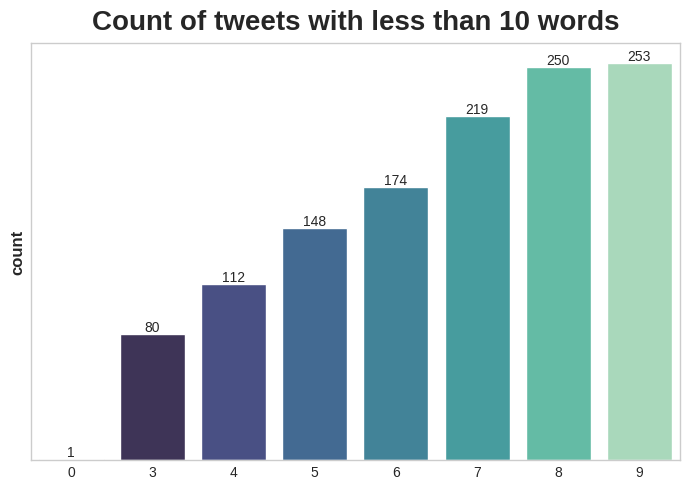

In [162]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

### What about long tweets?

In [163]:
df.sort_values(by=['text_len'], ascending=False)

,text,sentiment,text_clean,text_len
3207,Fuck Fuck georgegambnino georgegambnino Nigeri...,ethnicity,fuck fuck georgegambnino georgegambnino nigeri...,38
106,Matt lindo is a BIG WEIRDO& has always been si...,age,matt lindo big weirdo always since literally m...,36
3042,Mother's and son Dre (Jaden Smith) move to Chi...,age,mother son dre jaden smith move china job know...,36
3816,Get out the way #LGBTI COMMUNITY ACTIVIST ADVI...,gender,get way lgbti community activist advised one n...,36
2116,Fuck Fuck georgegambnino lickmykakez Nigeria N...,ethnicity,fuck fuck georgegambnino lickmykakez nigeria n...,35
...,...,...,...,...
1635,@lininger7 @natk16 @courthelml fuck you you du...,ethnicity,fuck dumb nigger,3
1649,@spoonsclass Merry Christmas to all of you fro...,not_cyberbullying,merry christmas heart,3
4189,Who hasn't cooked on a BBQ before?! #mkr,not_cyberbullying,cooked bbq mkr,3
4708,More shit that dudes don't have to put up with...,not_cyberbullying,shit dude put,3


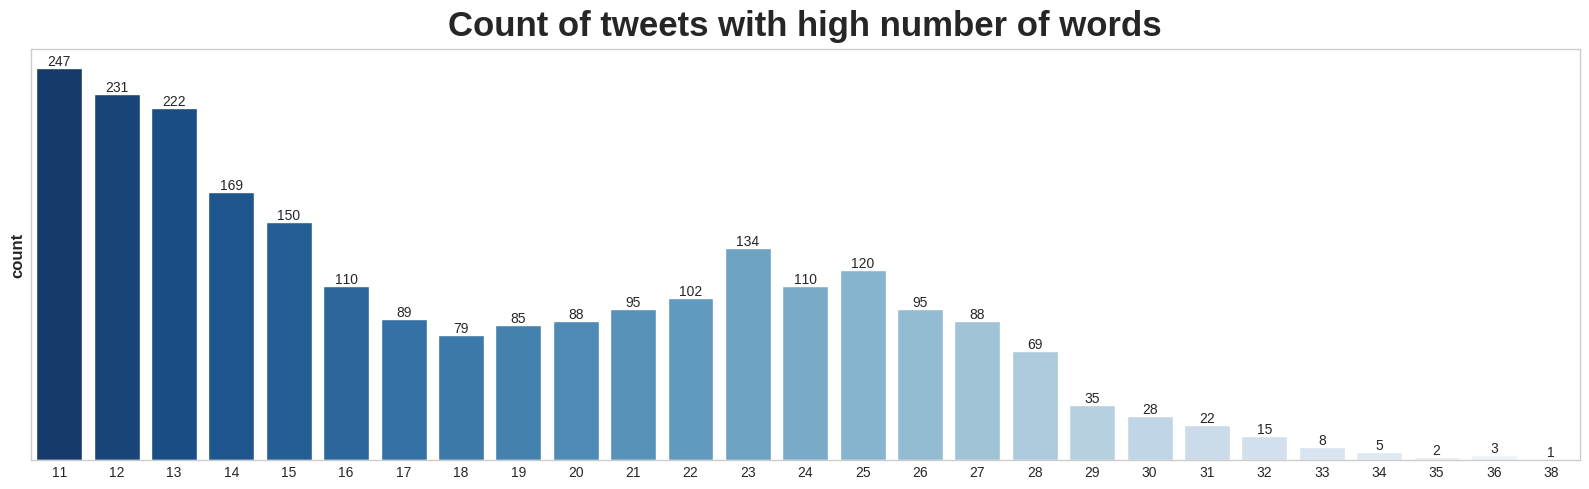

In [164]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=df[(df['text_len']<=1000) & (df['text_len']>10)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

We also will remove tweets that are long.

In [165]:
df = df[df['text_len'] < df['text_len'].quantile(0.995)]

Then we also get the length of the longest tweet since it will be useful later.

In [166]:
max_len = np.max(df['text_len'])
max_len

31

In [167]:
df.sort_values(by=["text_len"], ascending=False)

,text,sentiment,text_clean,text_len
1221,I'm waiting for them to go after Seth McFarlan...,gender,waiting go seth mcfarland family guy american ...,31
4335,Even men who claimed to be feminist are only p...,religion,even men claimed feminist pretending since daw...,31
3974,You mean how country folk want nothing to do w...,religion,mean country folk want nothing muslim blm move...,31
3997,Woke up with a heavy heart yaz I'm thinking ab...,age,woke heavy heart yaz thinking got bullied high...,31
3841,The best millennials could pick for humor in t...,gender,best millennials could pick humor early joke p...,31
...,...,...,...,...
1587,It's like that... Because you want it that way.,not_cyberbullying,like want way,3
3418,"0, would bully u at school",age,would bully school,3
3122,@LynnMagic some of it. Many moving parts.,not_cyberbullying,many moving part,3
2597,Your radio gets bullied,not_cyberbullying,radio get bullied,3


## Sentiment column encoding

The target column will be encoded by ordinal encoding

In [168]:
df['sentiment'] = df['sentiment'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4})

## Train - Test split

Now we need to split the dataset into a train and test sets.

In [169]:
X = df['text_clean']
y = df['sentiment']

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

## Train - Validation split

Moreover, we will further split the training set to extract a validation set, which will be used to monior the accuracy and loss to avoid overfitting during the model training.

In [171]:
# stratify=y_train, 根据目标变量里的种类进行抽样，在样本里种类不均衡时使用
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

In [172]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[  0, 522],
       [  1, 512],
       [  2, 488],
       [  3, 519],
       [  4, 408]])

The classes are unbalanced, so it could be a good idea to oversample the training set such that all classes have the same count as the most populated one.

# Oversampling of training set

In [173]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['text_clean', 'sentiment']);

In [174]:
X_train = train_os['text_clean'].values
y_train = train_os['sentiment'].values

In [175]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[  0, 522],
       [  1, 522],
       [  2, 522],
       [  3, 522],
       [  4, 522]])

# Naive Bayes baseline model

The first algorithm we will implement is Naive Bayes, which will be used as a simple baseline model. In order to use this algorithm, we need first need to preprocess the text data. <br>
First, we will create a bag of words using CountVectorizer.

In [176]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

Then we apply TF-IFD transformation to associate weigths to the different words based on their frequency (rarer words will be given more importance).

In [177]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

Finally we can instantiate the Naive Bayes model.

In [178]:
nb_clf = MultinomialNB()

In [179]:
nb_clf.fit(X_train_tf, y_train)

MultinomialNB()

In [180]:
nb_pred = nb_clf.predict(X_test_tf)

In [181]:
print('Classification Report for Naive Bayes:\n',classification_report(y_test, nb_pred, target_names=sentiments))

Classification Report for Naive Bayes:
               precision    recall  f1-score   support

    religion       0.85      0.97      0.91       163
         age       0.78      0.99      0.87       160
   ethnicity       0.88      0.93      0.91       152
      gender       0.89      0.86      0.87       163
not bullying       0.73      0.34      0.47       128

    accuracy                           0.84       766
   macro avg       0.83      0.82      0.81       766
weighted avg       0.83      0.84      0.82       766



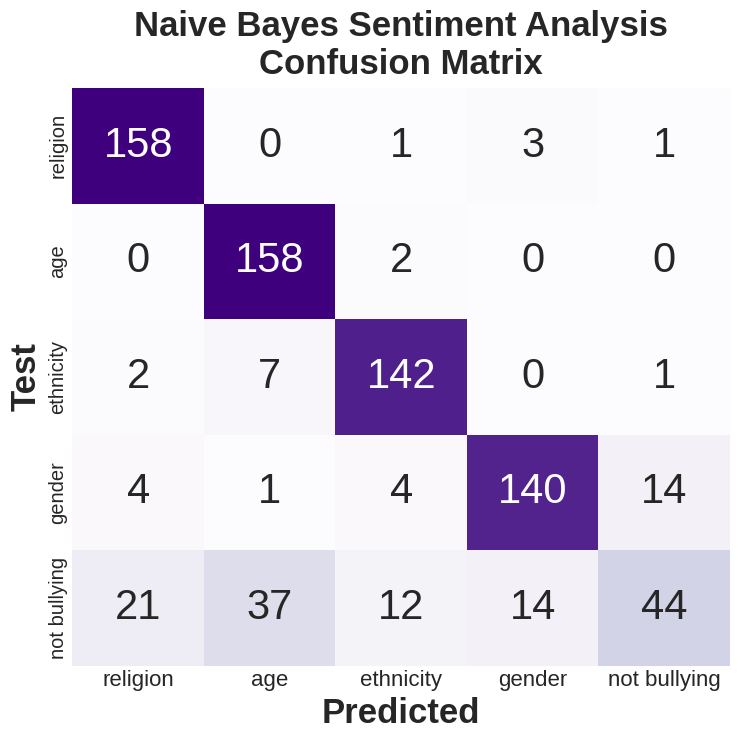

In [182]:
conf_matrix(y_test,nb_pred,'Naive Bayes Sentiment Analysis\nConfusion Matrix', sentiments)

**The performance scores of the algorithm is very good, with an overall accurcy of 87%.<br>
We can observe how the predictions for the more populated classes have very high F1 scores (over 85%), while for the class "non-cyberbullying" the score is much lower (58%).**

*Next we will implement a more complex algorithm to perform the classification, aiming to achieve higher accurcy than the baseline Naive Bayes model.*

# PyTorch LSTM RNN w/ Attention

In this section, we will define a custom Unidirectional and Bidirectional LSTM using PyTorch in order to perform the Sentiment Analysis on the tweets.

## Data preprocessing for LSTM

Similarly to what we did with Naive Bayes, we need to preprocess the data: in particular we will tokenize the sentences with a custom defined function. <br>
The sentences will be converted to lists of number with padding to the max number of words in a sentence.

In [266]:
def Tokenize(column, seq_len):
    ##Create vocabulary of words from column
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus)
    #print(count_words)
    sorted_words = count_words.most_common()
    #print(sorted_words)
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}
    #print(vocab_to_int)
    #print(vocab_to_int['school'])
    # 字典中key是按出现顺序排列的词，values是index

    ##Tokenize the columns text using the vocabulary
    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r) #text是每一行文本里面的单词对应的index，这里index我们按照频率降序排列
    #print(text_int)
    ##Add padding to tokens
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)
    #print(sorted_words)
    #print(features)
    return sorted_words, features, vocab_to_int # sorted_words里面是按从大到小出现的单词及次数，feature 里面每一行是一个tweet,
                                  # 数字代表词语出现的index，如果不满足最大长度，填充0

In [267]:
vocabulary, tokenized_column, vocab_to_int = Tokenize(df["text_clean"], max_len)

We can check how each tweet has been tokenized with an example:

In [268]:
df["text_clean"].iloc[0]

'girl used bully high school told happy birthday mean winning life'

This sentence is transformed to the vector:

In [269]:
tokenized_column[10]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0, 2674,   15,   32,    6,   26,  261,  192, 1036,  198,
        226,  672, 4013, 4014, 4015, 4016, 1037,  672, 4017])

Moreover we can also check the TOP 20 most common words by extracting them from the vocabulary python dictionary we created with the tokenizer.

In [270]:
keys = []
values = []
for key, value in vocabulary[:20]:
    keys.append(key)
    values.append(value)

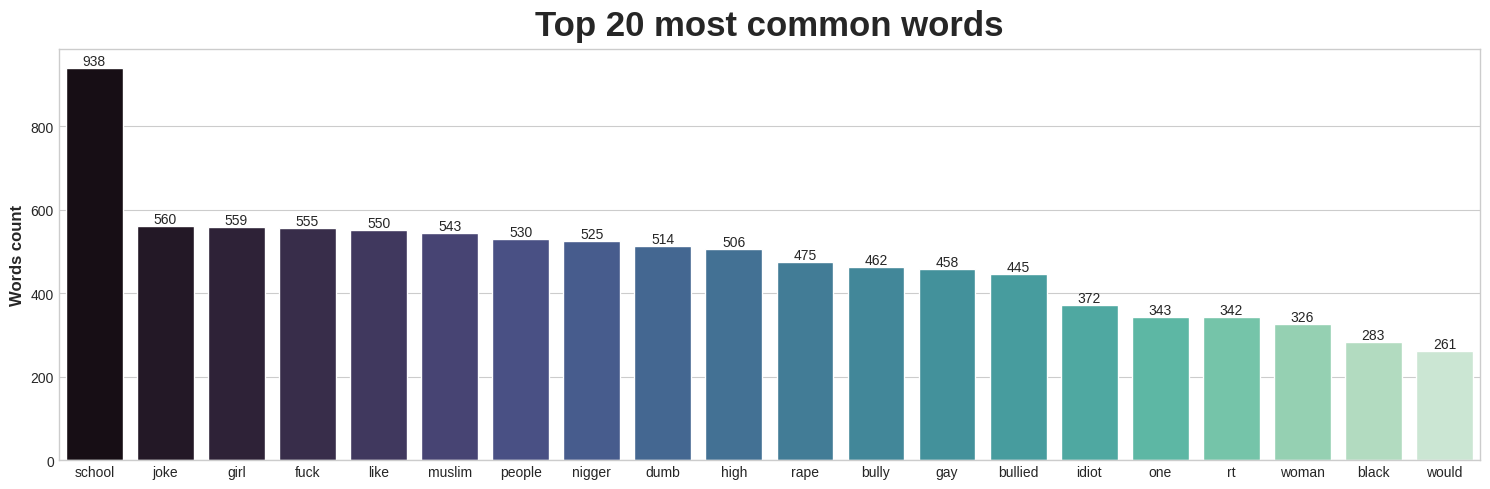

In [271]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=keys, y=values, palette='mako')
plt.title('Top 20 most common words', size=25)
ax.bar_label(ax.containers[0])
plt.ylabel("Words count")
plt.show()

# Word Embedding by Word2Vec

Next, we will create a word embedding matrix using the original text tweets and the pre trained model Word2vec.<br>
First, we create a list of words from the X_train vector created before.

In [272]:
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

We set a dimension of the embedding words, which can be seen as the number of featurs of each transformed word.

In [273]:
EMBEDDING_DIM = 200

Then we can instaniate the Word2Vec model by passing the training words and chosen embedding dimension to the imported Word2vec object.

In [274]:
word2vec_model = Word2Vec(Word2vec_train_data, vector_size=EMBEDDING_DIM)

Before defining the embedding matrix, we also need to choose the max number of words. We will extract the number of words from the vocabulary python dictionary we created before.

In [275]:
print(f"Vocabulary size: {len(vocabulary) + 1}")

Vocabulary size: 9781


In [276]:
VOCAB_SIZE = len(vocabulary) + 1 #+1 for the padding

Finally we can define the embedding matrix.

In [289]:
vocab_to_int = [(key, value) for key, value in vocab_to_int.items()]

In [290]:
# Define an empty embedding matrix of shape (VOCAB_SIZE, EMBEDDING_DIM)
# one word = one 200 dimensional vector
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

# Fill the embedding matrix with pre-trained values from word2vec
for word, token in vocab_to_int:
    # Check if the word is present in the word2vec model's vocabulary
    if word in word2vec_model.wv.key_to_index:
        # If the word is present, retrieve its embedding vector and add it to the embedding matrix
        embedding_vector = word2vec_model.wv[word] #word2vec_model.wv[word] 200 vector
        embedding_matrix[token] = embedding_vector

# Print the shape of the embedding matrix
print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (9781, 200)


In [303]:
embedding_matrix[1] # school

array([-4.29077260e-02, -1.12506099e-01, -1.02071486e-01,  3.76140863e-01,
        3.73258024e-01, -2.62232870e-01, -6.12813979e-02,  6.79341912e-01,
       -1.49724707e-01,  3.26863468e-01, -1.08975857e-01, -2.27149919e-01,
        2.07497217e-02,  3.33375663e-01, -2.41928786e-01, -2.28242025e-01,
       -5.41295372e-02,  3.63112278e-02,  2.59222835e-03, -6.39017045e-01,
        1.53570786e-01, -3.27785015e-01, -2.30684638e-01,  1.00112781e-01,
       -6.13987632e-02, -1.69081807e-01, -1.10854901e-01, -3.86636615e-01,
       -4.45758075e-01,  3.03333580e-01,  3.33963931e-01,  1.99110955e-02,
        6.60203397e-02, -4.77167852e-02,  3.70943267e-03,  2.91428775e-01,
        2.78318733e-01, -1.77471116e-01, -1.21964067e-01, -4.13251013e-01,
       -2.63566166e-01,  1.52965402e-03, -4.96287607e-02,  9.81644019e-02,
        6.13864839e-01, -6.24046836e-04, -6.89792633e-02, -2.32947171e-01,
        3.10340852e-01,  2.61851728e-01,  1.96325853e-01, -7.19647408e-02,
       -2.51370013e-01, -

## Train - Validation - Test split

Now we will use the tokenized sentences to create a training, validation and test datasets.

In [321]:
tokenized_column

array([[   0,    0,    0, ...,   63, 1617,   75],
       [   0,    0,    0, ...,  160,  118,   90],
       [   0,    0,    0, ..., 2031, 4000, 2032],
       ...,
       [   0,    0,    0, ...,   22,    8,  642],
       [   0,    0,    0, ...,  155,    1,   57],
       [   0,    0,    0, ...,   10,    1,    3]])

In [304]:
X = tokenized_column
y = df['sentiment'].values

In [305]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [306]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

We can check the balance of the target classes:

In [307]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[  0, 522],
       [  1, 512],
       [  2, 488],
       [  3, 519],
       [  4, 408]])

And then apply random oversampling on the training set.

In [308]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train),np.array(y_train));

In [309]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[  0, 522],
       [  1, 522],
       [  2, 522],
       [  3, 522],
       [  4, 522]])

## PyTorch datasets and dataloaders

The three sets will be transformed to tensor datasets and dataloaders so we can extract the data in batches for the LSTM training, validation and testing.

In [310]:
train_data = TensorDataset(torch.from_numpy(X_train_os), torch.from_numpy(y_train_os))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

In [311]:
BATCH_SIZE = 32 #一次训练的样本数量

In [312]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

# PyTorch LSTM modeling with Attention Layer

In this chapter we implement two Python classes: Attention and LSTM_Sentiment_Classifier.

The Attention class defines our attention mechanism. This technique is commonly used in Natural Language Processing tasks to allow our model to focus on specific parts of the input sequence when generating output. It learns to assign weights to different parts of the input data, indicating their relevance. This class initializes an attention layer which takes into account whether our LSTM network is bidirectional or not.

In the Attention class forward method, we first calculate the attention weights. These weights are computed by applying a tanh activation function to the concatenated hidden states and encoder outputs. A softmax is then applied to the attention weights, ensuring they sum to 1 and hence can be interpreted as probabilities.

Next, we define our LSTM_Sentiment_Classifier class, which uses the Attention mechanism to make predictions. This class includes an LSTM network which takes embedded word representations as input and outputs hidden states. It also includes an attention layer, which uses these hidden states to compute attention weights and apply them to the encoder outputs to get a context vector. This context vector is passed through a fully connected layer followed by a log-softmax function to produce the final output probabilities.

In the forward method of LSTM_Sentiment_Classifier, we pass our inputs through an embedding layer, followed by the LSTM network. We then calculate the attention weights and form a context vector. This context vector serves as a summary of the entire input sequence, weighted by the attention mechanism's output. We pass this context vector through a fully connected layer and a log-softmax function to make our final prediction.

Lastly, we define a method init_hidden to initialize the hidden state of our LSTM network. Depending on whether our LSTM network is bidirectional or not, we may need to double the size of our hidden state.

This LSTM model with attention allows us to better handle the complexities of language understanding by giving more importance to the relevant parts of our text data. This enhances the model's ability to understand context and thereby, improves the performance of our Sentiment Analysis task.

In [313]:
class Attention(nn.Module):
    def __init__(self, hidden_dim, is_bidirectional):
        super(Attention, self).__init__()
        self.is_bidirectional = is_bidirectional
        # The attention linear layer which transforms the input data to the hidden space
        self.attn = nn.Linear(hidden_dim * (4 if is_bidirectional else 2), hidden_dim * (2 if is_bidirectional else 1))
        # The linear layer that calculates the attention scores
        self.v = nn.Linear(hidden_dim * (2 if is_bidirectional else 1), 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        seq_len = encoder_outputs.size(1)
        # Concatenate the last two hidden states in case of a bidirectional LSTM
        if self.is_bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=-1)
        else:
            hidden = hidden[-1]
        # Repeat the hidden state across the sequence length
        hidden_repeated = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        # Calculate attention weights
        attn_weights = torch.tanh(self.attn(torch.cat((hidden_repeated, encoder_outputs), dim=2)))
        # Compute attention scores
        attn_weights = self.v(attn_weights).squeeze(2)
        # Apply softmax to get valid probabilities
        return nn.functional.softmax(attn_weights, dim=1)


class LSTM_Sentiment_Classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, dropout, is_bidirectional):
        super(LSTM_Sentiment_Classifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = lstm_layers
        self.is_bidirectional = is_bidirectional

        # The Embedding layer that converts input words to embeddings
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM layer which processes the embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, lstm_layers, batch_first=True, bidirectional=is_bidirectional)
        # Attention layer to compute the context vector
        self.attention = Attention(hidden_dim, is_bidirectional)
        # Fully connected layer which classifies the context vector into classes
        self.fc = nn.Linear(hidden_dim * (2 if is_bidirectional else 1), num_classes)
        # Apply LogSoftmax to outputs for numerical stability
        self.softmax = nn.LogSoftmax(dim=1)
        # Dropout layer for regularisation
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden):
        # Transform words to embeddings
        embedded = self.embedding(x)
        # Pass embeddings to LSTM
        out, hidden = self.lstm(embedded, hidden)
        # Calculate attention weights
        attn_weights = self.attention(hidden[0], out)
        # Calculate context vector by taking the weighted sum of LSTM outputs
        context = attn_weights.unsqueeze(1).bmm(out).squeeze(1)
        # Classify the context vector
        out = self.softmax(self.fc(context))
        return out, hidden

    def init_hidden(self, batch_size):
        # Factor determines the size of hidden states depending on bidirectionality
        factor = 2 if self.is_bidirectional else 1
        # Initial hidden and cell states are zero
        h0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim).to(DEVICE)
        c0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim).to(DEVICE)

In [314]:
NUM_CLASSES = 5 #We are dealing with a multiclass classification of 5 classes
HIDDEN_DIM = 100 #number of neurons of the internal state (internal neural network in the LSTM)
LSTM_LAYERS = 1 #Number of stacked LSTM layers

IS_BIDIRECTIONAL = False # Set this to False for unidirectional LSTM, and True for bidirectional LSTM

LR = 4e-4 #Learning rate
DROPOUT = 0.5 #LSTM Dropout
EPOCHS = 10 #Number of training epoch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = LSTM_Sentiment_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, LSTM_LAYERS, DROPOUT, IS_BIDIRECTIONAL)

model = model.to(DEVICE)

# Initialize the embedding layer with the previously defined embedding matrix
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
# Allow the embedding matrix to be fine-tuned to better adapt to our dataset and get higher accuracy
model.embedding.weight.requires_grad = True

# Set up the criterion (loss function)
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay = 5e-6)

print(model)

LSTM_Sentiment_Classifier(
  (embedding): Embedding(9781, 200)
  (lstm): LSTM(200, 100, batch_first=True)
  (attention): Attention(
    (attn): Linear(in_features=200, out_features=100, bias=True)
    (v): Linear(in_features=100, out_features=1, bias=False)
  )
  (fc): Linear(in_features=100, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
  (dropout): Dropout(p=0.5, inplace=False)
)


# LSTM Training loop

Now we will define a custom training loop, where we include an early stopping functionality, and save only the best models in terms of validation accuracy.

In [315]:
total_step = len(train_loader)
total_step_val = len(valid_loader)

early_stopping_patience = 4
early_stopping_counter = 0

valid_acc_max = 0 # Initialize best accuracy top 0

for e in range(EPOCHS):

    #lists to host the train and validation losses of every batch for each epoch
    train_loss, valid_loss  = [], []
    #lists to host the train and validation accuracy of every batch for each epoch
    train_acc, valid_acc  = [], []

    #lists to host the train and validation predictions of every batch for each epoch
    y_train_list, y_val_list = [], []

    #initalize number of total and correctly classified texts during training and validation
    correct, correct_val = 0, 0
    total, total_val = 0, 0
    running_loss, running_loss_val = 0, 0


    ####TRAINING LOOP####

    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) #load features and targets in device

        h = model.init_hidden(labels.size(0))

        model.zero_grad() #reset gradients

        output, h = model(inputs,h) #get output and hidden states from LSTM network

        loss = criterion(output, labels)
        loss.backward()

        running_loss += loss.item()

        optimizer.step()

        y_pred_train = torch.argmax(output, dim=1) #get tensor of predicted values on the training set
        y_train_list.extend(y_pred_train.squeeze().tolist()) #transform tensor to list and the values to the list

        correct += torch.sum(y_pred_train==labels).item() #count correctly classified texts per batch
        total += labels.size(0) #count total texts per batch

    train_loss.append(running_loss / total_step)
    train_acc.append(100 * correct / total)

    ####VALIDATION LOOP####

    with torch.no_grad():

        model.eval()

        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            val_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, val_h)

            val_loss = criterion(output, labels)
            running_loss_val += val_loss.item()

            y_pred_val = torch.argmax(output, dim=1)
            y_val_list.extend(y_pred_val.squeeze().tolist())

            correct_val += torch.sum(y_pred_val==labels).item()
            total_val += labels.size(0)

        valid_loss.append(running_loss_val / total_step_val)
        valid_acc.append(100 * correct_val / total_val)

    #Save model if validation accuracy increases
    if np.mean(valid_acc) >= valid_acc_max:
        torch.save(model.state_dict(), './state_dict.pt')
        print(f'Epoch {e+1}:Validation accuracy increased ({valid_acc_max:.6f} --> {np.mean(valid_acc):.6f}).  Saving model ...')
        valid_acc_max = np.mean(valid_acc)
        early_stopping_counter=0 #reset counter if validation accuracy increases
    else:
        print(f'Epoch {e+1}:Validation accuracy did not increase')
        early_stopping_counter+=1 #increase counter if validation accuracy does not increase

    if early_stopping_counter > early_stopping_patience:
        print('Early stopped at epoch :', e+1)
        break

    print(f'\tTrain_loss : {np.mean(train_loss):.4f} Val_loss : {np.mean(valid_loss):.4f}')
    print(f'\tTrain_acc : {np.mean(train_acc):.3f}% Val_acc : {np.mean(valid_acc):.3f}%')

Epoch 1:Validation accuracy increased (0.000000 --> 41.940789).  Saving model ...
	Train_loss : 1.5260 Val_loss : 1.3848
	Train_acc : 32.948% Val_acc : 41.941%
Epoch 2:Validation accuracy increased (41.940789 --> 77.138158).  Saving model ...
	Train_loss : 1.0535 Val_loss : 0.7580
	Train_acc : 65.548% Val_acc : 77.138%
Epoch 3:Validation accuracy increased (77.138158 --> 86.677632).  Saving model ...
	Train_loss : 0.5337 Val_loss : 0.4328
	Train_acc : 85.378% Val_acc : 86.678%
Epoch 4:Validation accuracy increased (86.677632 --> 88.651316).  Saving model ...
	Train_loss : 0.3192 Val_loss : 0.3542
	Train_acc : 90.201% Val_acc : 88.651%
Epoch 5:Validation accuracy did not increase
	Train_loss : 0.2168 Val_loss : 0.3720
	Train_acc : 93.904% Val_acc : 87.336%
Epoch 6:Validation accuracy did not increase
	Train_loss : 0.1552 Val_loss : 0.3964
	Train_acc : 96.026% Val_acc : 87.171%
Epoch 7:Validation accuracy increased (88.651316 --> 88.980263).  Saving model ...
	Train_loss : 0.1209 Val_los

In [316]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))

<All keys matched successfully>

# LSTM Testing

In [317]:
def evaluate_model(model, test_loader):
    model.eval()
    y_pred_list = []
    y_test_list = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            test_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, test_h)
            y_pred_test = torch.argmax(output, dim=1)
            y_pred_list.extend(y_pred_test.squeeze().tolist())
            y_test_list.extend(labels.squeeze().tolist())

    return y_pred_list, y_test_list

y_pred_list, y_test_list = evaluate_model(model, test_loader)

In [318]:
print('Classification Report for Bi-LSTM :\n', classification_report(y_test_list, y_pred_list, target_names=sentiments))

Classification Report for Bi-LSTM :
               precision    recall  f1-score   support

    religion       0.97      0.90      0.93       158
         age       0.92      0.97      0.95       151
   ethnicity       0.92      0.94      0.93       146
      gender       0.90      0.80      0.85       157
not bullying       0.72      0.81      0.76       124

    accuracy                           0.89       736
   macro avg       0.89      0.89      0.88       736
weighted avg       0.89      0.89      0.89       736



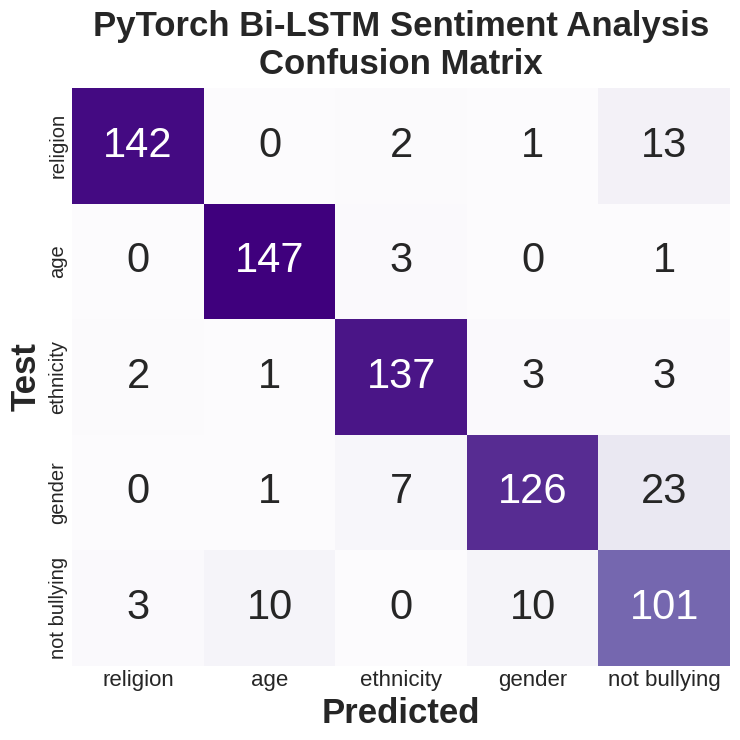

In [319]:
conf_matrix(y_test_list,y_pred_list,'PyTorch Bi-LSTM Sentiment Analysis\nConfusion Matrix', sentiments)

**The performance scores of the algorithm are very high, with an overall accuracy of 93%.**<br>
**In particular, the F1 scores for the more populated classes are over 95%**

# BERT Classification

In this section, we will load a pre trained BERT model from the Hugging Face library and fine tune it for our classification task.

First, we need to split the dataset into train - validation - test again since we need to tokenize the sentences differently from before (Naive Bayes and LSTM).

## Train - Validation - Test split

In [71]:
X = df['text_clean'].values
y = df['sentiment'].values

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [73]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

As seen before, we oversample the text to the majority class.

In [74]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train).reshape(-1,1),np.array(y_train).reshape(-1,1))

In [75]:
X_train_os = X_train_os.flatten()
y_train_os = y_train_os.flatten()

In [76]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[  0, 522],
       [  1, 522],
       [  2, 522],
       [  3, 522],
       [  4, 522]])

# BERT Tokenization

Since we need to tokenize the tweets (get "input ids" and "attention masks") for BERT, we load the specific BERT tokenizer from the Hugging Face library.

In [77]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Then we define a custom tokenizer function using the loaded tokenizer.

In [78]:
def bert_tokenizer(data):
    input_ids = []
    attention_masks = []
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]` special tokens
            max_length=MAX_LEN,             # Choose max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            return_attention_mask=True      # Return attention mask
            )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Since we need to specify the length of the longest tokenized sentence, we tokenize the train tweets using the "encode" method of the original BERT tokenizer and check the longest sentence.

In [79]:
# Tokenize train tweets
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in X_train]

# Find the longest tokenized tweet
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  54


We can choose the max length as 128.

In [80]:
MAX_LEN = 128

Then we can tokenize the train, validation and test tweets using the custom define tokenizer.

In [81]:
train_inputs, train_masks = bert_tokenizer(X_train_os)
val_inputs, val_masks = bert_tokenizer(X_valid)
test_inputs, test_masks = bert_tokenizer(X_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Data preprocessing for PyTorch BERT model

Since we are using the BERT model built on PyTorch, we need to convert the arrays to pytorch tensors and create dataloaders for the data.

In [82]:
# Convert target columns to pytorch tensors format
train_labels = torch.from_numpy(y_train_os)
val_labels = torch.from_numpy(y_valid)
test_labels = torch.from_numpy(y_test)

## Dataloaders

To fine-tune the BERT model, the original authors recommend a batch size of 16 or 32.

In [83]:
batch_size = 32

In [84]:
# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# BERT Modeling

Now we can create a custom BERT classifier class, including the original BERT model (made of transformer layers) and additional Dense layers to perform the desired classification task.

In [85]:
class Bert_Classifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(Bert_Classifier, self).__init__()
        # Specify hidden size of BERT, hidden size of the classifier, and number of labels
        n_input = 768
        n_hidden = 50
        n_output = 5

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate the classifier (a fully connected layer followed by a ReLU activation and another fully connected layer)
        self.classifier = nn.Sequential(
            nn.Linear(n_input, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_output)
        )

        # Freeze the BERT model weights if freeze_bert is True (useful for feature extraction without fine-tuning)
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        # Feed input data (input_ids and attention_mask) to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the `[CLS]` token from the BERT output (useful for classification tasks)
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed the extracted hidden state to the classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

Moreover, since we want to define a learning rate scheduler, we define a custom "initalize_model" function as follows.

In [86]:
# Function for initializing the BERT Classifier model, optimizer, and learning rate scheduler
def initialize_model(epochs=4):
    # Instantiate Bert Classifier
    bert_classifier = Bert_Classifier(freeze_bert=False)

    bert_classifier.to(device)

    # Set up optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # learning rate, set to default value
                      eps=1e-8    # decay, set to default value
                      )

    # Calculate total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Define the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

We also specify the use of GPU if present (highly recommended for the fine tuning)

In [87]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS=2

And then we intialize the BERT model calling the "initialize_model" function we defined.

In [88]:
bert_classifier, optimizer, scheduler = initialize_model(epochs=EPOCHS)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# BERT Training

After defining the custom BERT classifier model, we are ready to start the training.

In [89]:
# Define Cross entropy Loss function for the multiclass classification task
loss_fn = nn.CrossEntropyLoss()

def bert_train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):

    print("Start training...\n")
    for epoch_i in range(epochs):
        print("-"*10)
        print("Epoch : {}".format(epoch_i+1))
        print("-"*10)
        print("-"*38)
        print(f"{'BATCH NO.':^7} | {'TRAIN LOSS':^12} | {'ELAPSED (s)':^9}")
        print("-"*38)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        ###TRAINING###

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1

            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass and get logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update model parameters:
            # fine tune BERT params and train additional dense layers
            optimizer.step()
            # update learning rate
            scheduler.step()

            # Print the loss values and time elapsed for every 100 batches
            if (step % 100 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                print(f"{step:^9} | {batch_loss / batch_counts:^12.6f} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        ###EVALUATION###

        # Put the model into the evaluation mode
        model.eval()

        # Define empty lists to host accuracy and validation for each batch
        val_accuracy = []
        val_loss = []

        for batch in val_dataloader:
            batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device) for t in batch)

            # We do not want to update the params during the evaluation,
            # So we specify that we dont want to compute the gradients of the tensors
            # by calling the torch.no_grad() method
            with torch.no_grad():
                logits = model(batch_input_ids, batch_attention_mask)

            loss = loss_fn(logits, batch_labels)

            val_loss.append(loss.item())

            # Get the predictions starting from the logits (get index of highest logit)
            preds = torch.argmax(logits, dim=1).flatten()

            # Calculate the validation accuracy
            accuracy = (preds == batch_labels).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)

        # Compute the average accuracy and loss over the validation set
        val_loss = np.mean(val_loss)
        val_accuracy = np.mean(val_accuracy)

        # Print performance over the entire training data
        time_elapsed = time.time() - t0_epoch
        print("-"*61)
        print(f"{'AVG TRAIN LOSS':^12} | {'VAL LOSS':^10} | {'VAL ACCURACY (%)':^9} | {'ELAPSED (s)':^9}")
        print("-"*61)
        print(f"{avg_train_loss:^14.6f} | {val_loss:^10.6f} | {val_accuracy:^17.2f} | {time_elapsed:^9.2f}")
        print("-"*61)
        print("\n")

    print("Training complete!")

In [90]:
bert_train(bert_classifier, train_dataloader, val_dataloader, epochs=EPOCHS)

Start training...

----------
Epoch : 1
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   81     |   0.764407   |  3490.83 
-------------------------------------------------------------
AVG TRAIN LOSS |  VAL LOSS  | VAL ACCURACY (%) | ELAPSED (s)
-------------------------------------------------------------
   0.764407    |  0.348482  |       90.47       |  3752.08 
-------------------------------------------------------------


----------
Epoch : 2
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   81     |   0.257986   |  3358.90 
-------------------------------------------------------------
AVG TRAIN LOSS |  VAL LOSS  | VAL ACCURACY (%) | ELAPSED (s)
-------------------------------------------------------------
   0.257986    |  0.307314  |       90.78       |  3625.10 
-------------------------------------------------------

# BERT Prediction

Now we define a function similar to the model "evaluation", where we feed to the model the test data instead of the validation data.

In [91]:
def bert_predict(model, test_dataloader):

    # Define empty list to host the predictions
    preds_list = []

    # Put the model into evaluation mode
    model.eval()

    for batch in test_dataloader:
        batch_input_ids, batch_attention_mask = tuple(t.to(device) for t in batch)[:2]

        # Avoid gradient calculation of tensors by using "no_grad()" method
        with torch.no_grad():
            logit = model(batch_input_ids, batch_attention_mask)

        # Get index of highest logit
        pred = torch.argmax(logit,dim=1).cpu().numpy()
        # Append predicted class to list
        preds_list.extend(pred)

    return preds_list

Then we can call the defined function and get the class predictions of the test data.

In [92]:
bert_preds = bert_predict(bert_classifier, test_dataloader)

In [93]:
print('Classification Report for BERT :\n', classification_report(y_test, bert_preds, target_names=sentiments))

Classification Report for BERT :
               precision    recall  f1-score   support

    religion       0.96      0.99      0.97       164
         age       0.96      0.97      0.97       160
   ethnicity       0.95      0.97      0.96       153
      gender       0.88      0.89      0.88       163
not bullying       0.81      0.72      0.76       126

    accuracy                           0.92       766
   macro avg       0.91      0.91      0.91       766
weighted avg       0.91      0.92      0.91       766



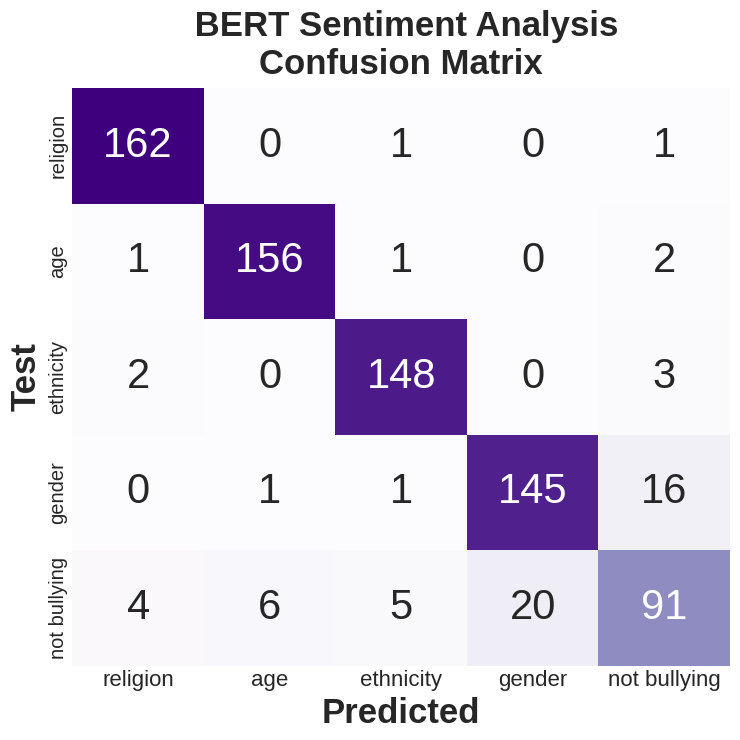

In [94]:
conf_matrix(y_test, bert_preds,' BERT Sentiment Analysis\nConfusion Matrix', sentiments)

**The performance scores of BERT Classifier are quite high and higher than those achieved using the LSTM model, with an overall accuracy around 95% and F1 scores well over 95%.**<br>

Thank your for checking out my notebook! Let me know if you have comments or if you want me to check out your work! :)